In [1]:
import os, shutil
from glob import glob
import numpy as np
import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from torchvision import transforms
from torchvision import models
import torch
from torch import Tensor
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torch.utils.data as Data

In [35]:
classes = ["cane", "cavallo", "elefante", "farfalla", "gallina", "gatto", "mucca", "pecora", "ragno", "scoiattolo"]

def clean_train_test(clss):
    tst = "./test/" + clss + "/*"
    train = "./train/" + clss + "/*"
    tst_files, train_files = glob(tst), glob(train)
    for f in tst_files:
        os.remove(f)
    for f in train_files:
        os.remove(f)

def create_train_test():
    if not os.path.exists("./train") and not os.path.exists("./test"):
        os.makedirs("./train")
        os.makedirs("./test")

    for clss in classes:
        clss_source = "./input/" + clss
        clean_train_test(clss)

        
        allFileNames = os.listdir(clss_source)
        np.random.shuffle(allFileNames)
        test_ratio = 0.3
        train_FileNames, test_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames)* (1 - test_ratio))])
        train_FileNames = [clss_source+'/'+ name for name in train_FileNames.tolist()]
        test_FileNames = [clss_source+'/' + name for name in test_FileNames.tolist()]

        for name in train_FileNames:
            shutil.copy(name, './train/' + clss)

        for name in test_FileNames:
            shutil.copy(name, './test/' + clss)

In [3]:
create_train_test()

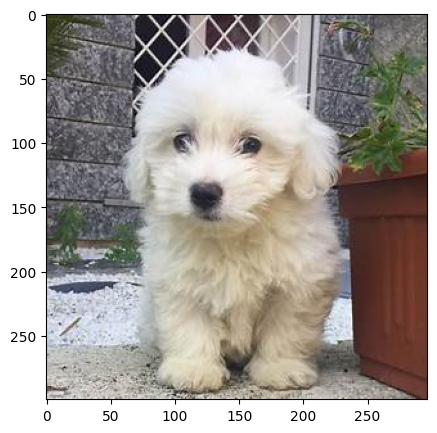

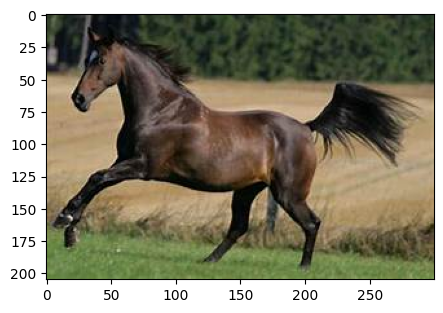

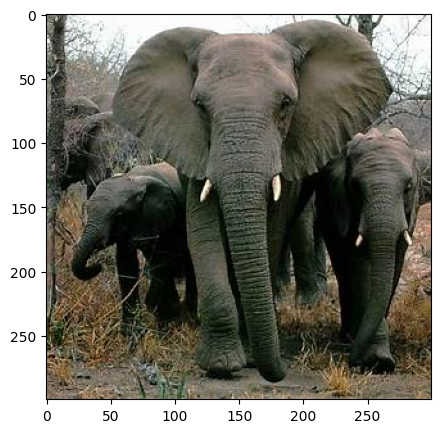

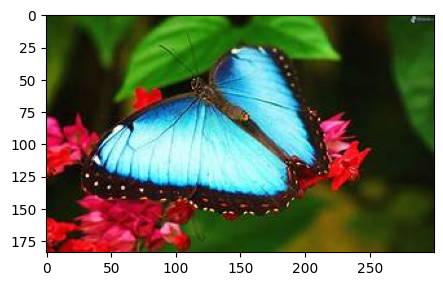

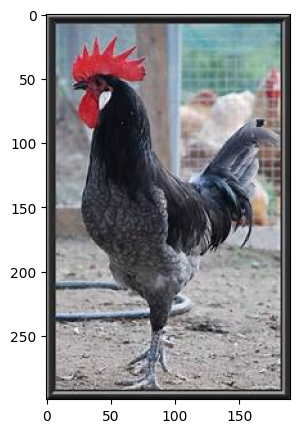

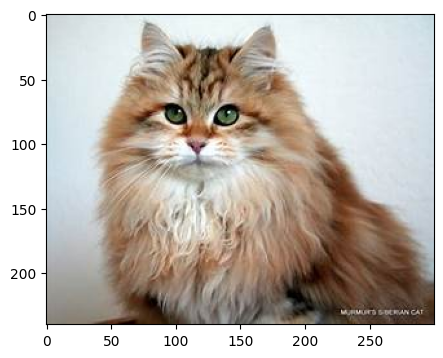

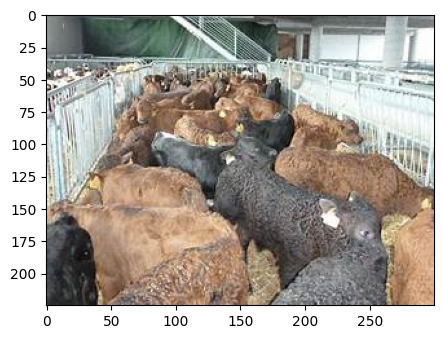

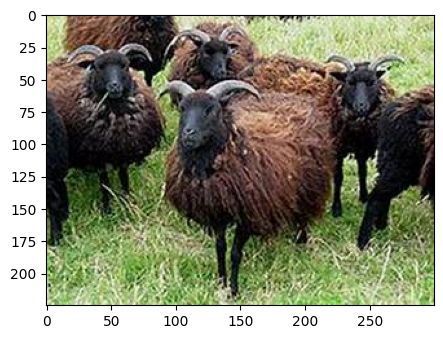

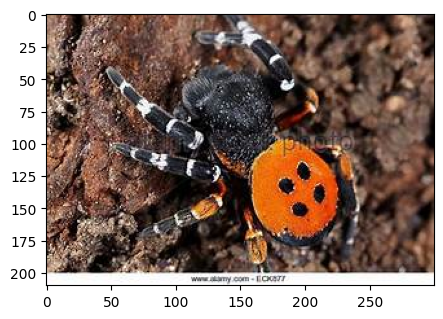

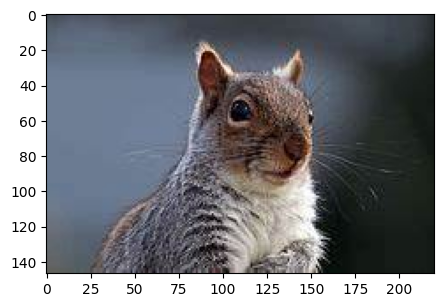

In [4]:
train_dir = "./train"
test_dir = "./test"

# train_folder = ImageFolder(train_dir)
# test_folder = ImageFolder(test_dir)

for path in os.listdir(train_dir):
    temp_path = os.path.join(train_dir, path)
    file = random.choice(os.listdir(temp_path))
    img_path = os.path.join(temp_path, file)

    img = mpimg.imread(img_path)
    plt.figure(figsize=(5,5))
    plt.imshow(img)

In [5]:
IMG_HEIGHT = 200
IMG_WIDTH = 200

def create_ds(dir):
    img_data_array, class_name = [], []

    classes = {"cane":          [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               "cavallo":       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
               "elefante":      [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
               "farfalla":      [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
               "gallina":       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
               "gatto":         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
               "mucca":         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
               "pecora":        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
               "ragno":         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
               "scoiattolo":    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]}
    
    for path in os.listdir(dir):
        for file in os.listdir(os.path.join(dir, path)):
            img_path = os.path.join(dir, path, file)

            img = cv2.imread(img_path, cv2.COLOR_BGR2RGB)

            img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_AREA)

            img = np.array(img).astype("float64")

            img /= 255

            if len(img.shape) == 3:
                img_data_array.append(np.array(img).reshape([3, IMG_HEIGHT, IMG_WIDTH]))
                class_name.append(classes[path])
    return img_data_array, class_name

In [6]:
train_img_data, train_class_names = create_ds("./train")
test_img_data, test_class_names = create_ds("./test")

print(len(train_img_data))
print(len(test_img_data))

18321
7857


In [7]:
train_ds = Data.TensorDataset(
    torch.Tensor(np.array(train_img_data)),
    torch.Tensor(np.array(train_class_names))
)

test_ds = Data.TensorDataset(
    torch.Tensor(np.array(test_img_data)),
    torch.Tensor(np.array(test_class_names))
)

trainloader = Data.DataLoader(
    train_ds,
    batch_size=16,
    shuffle=True,
    num_workers=2
)

testloader = Data.DataLoader(
    test_ds,
    batch_size=16,
    shuffle=True,
    num_workers=2
)

dataiter = iter(trainloader)
images = next(dataiter)
images[0].shape

torch.Size([16, 3, 200, 200])

In [48]:
class CNNNet(nn.Module):
    def __init__(self):
        super().__init__()
        # self.conv1 = nn.Conv2d(3, 6, 5)
        # self.pool = nn.MaxPool2d(2, 2)
        # self.conv2 = nn.Conv2d(6, 16, 5)
        # self.fc1 = nn.Linear(35344, 120)
        # self.fc2 = nn.Linear(120, 84)
        # self.fc3 = nn.Linear(84, 10)

        self.cnn_layers = nn.Sequential(
            # Define a 2D convolution layer with 3 input channels, 16 output channels, and a 5x5 kernel
            nn.Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Define another convolution layer with 16 input channels, 3 output channels, and a 50x50 kernel
            nn.Conv2d(16, 8, kernel_size=(50, 50), stride=(1, 1)),
            nn.MaxPool2d(kernel_size=1, stride=1, padding=0, ceil_mode=False)
        )

        self.linear_layers = nn.Sequential(
            # Define a fully connected layer with 3 input features and 3 output features
            nn.Linear(8, 10)
        )

    def forward(self, x):
        # x = self.pool(F.relu(self.conv1(x)))
        # x = self.pool(F.relu(self.conv2(x)))
        # x = torch.flatten(x, 1) # flatten all dimensions except batch
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = self.fc3(x)

        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x
    
# Define the model, optimizer, and loss function
model = CNNNet()  # Create an instance of the CNNNet class
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Define the optimizer with a learning rate of 0.0001
criterion = nn.CrossEntropyLoss()  # Define the loss function as Cross-Entropy Loss

# Check if GPU is available and move the model and loss function to the GPU if it is
print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    model = model.to("cuda")
    criterion = criterion.to("cuda")

# Print the model architecture
print(model)

CUDA Available: True
CNNNet(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 8, kernel_size=(50, 50), stride=(1, 1))
    (4): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=8, out_features=10, bias=True)
  )
)


In [49]:
# Training the model for 10 epochs
for epoch in range(10):
    running_loss = 0
    model.train()  # Set the model to training mode
    for i, data in enumerate(trainloader, 0):
        images, labels = data
        if torch.cuda.is_available():
            images = images.to("cuda")
            labels = labels.to("cuda")

        optimizer.zero_grad()

        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

[1,  1000] loss: 1.051
[2,  1000] loss: 0.918
[3,  1000] loss: 0.838
[4,  1000] loss: 0.754
[5,  1000] loss: 0.651
[6,  1000] loss: 0.549
[7,  1000] loss: 0.457
[8,  1000] loss: 0.370
[9,  1000] loss: 0.299
[10,  1000] loss: 0.243


In [13]:
savepath = "./output/model.pt"

torch.save(model.state_dict(), savepath)

In [50]:
# Create empty lists to store predicted and true labels
y_pred_list = []  # Predicted labels
y_true_list = []  # True labels

# Disable gradient calculations for inference
model.eval()
with torch.no_grad():
    for x_batch, y_batch in testloader:
        x_batch, y_batch = x_batch.to("cuda"), y_batch.to("cuda")
        
        # Perform inference with the model
        y_test_pred = model(x_batch)
        print(y_test_pred)  # Display the model's predictions
        
        # Find the predicted class labels
        _, y_pred_tag = torch.max(y_test_pred, dim=1)
        
        # Extend the lists with the predicted and true labels
        y_pred_list.extend(y_pred_tag.cpu().numpy())
        y_true_list.extend(y_batch.cpu().numpy())

tensor([[ 7.5397e-01, -6.4156e-01, -5.1522e-01, -1.5987e+00, -7.7262e-01,
          6.1568e-01, -1.0199e+00,  7.4540e-01,  2.2835e+00, -5.9761e-01],
        [ 5.7873e+00,  4.6009e+00,  3.7523e+00, -9.0271e+00, -1.6290e-01,
          6.9644e-01, -3.2592e+00, -1.4476e+01,  7.4624e-01, -3.0979e+00],
        [ 8.8587e+00,  2.8825e+00, -1.6163e+01, -6.7797e+00,  1.7569e+01,
         -3.7633e+00, -5.2029e-01,  1.2763e+00, -8.7499e+00, -1.1586e+01],
        [ 5.0146e+00, -1.7853e+00,  1.9587e+00, -6.6606e+00,  2.3401e+00,
          3.5411e+00, -2.7492e+00, -3.4911e+00,  2.6659e+00, -5.0322e-02],
        [ 2.9513e-01,  3.0903e+00, -4.0443e+00, -2.9093e+00, -7.2741e-01,
         -5.7977e+00,  1.5290e+00,  3.2565e+00, -1.8420e+00,  6.7300e-01],
        [ 3.7802e+00, -3.5774e+00, -2.5277e+00, -1.7630e+00, -4.0825e+00,
          5.2620e+00,  5.7378e-01,  4.8898e+00, -1.8801e+00, -4.7124e-01],
        [ 6.9393e+00,  1.0457e+01, -6.8958e+00, -1.0679e+01, -9.4318e+00,
         -2.1920e+01,  4.6352e+0

In [51]:
y_true_list_max = [m.argmax() for m in y_true_list]

In [52]:
correct_count, all_count = 0, 0

# Compare predicted labels (y_pred_list) with true labels (y_true_list_max)
for i in range(len(y_pred_list)):
    if y_pred_list[i] == y_true_list_max[i]:
        correct_count += 1
    all_count += 1

# Calculate and print the model accuracy
accuracy = correct_count / all_count
print("Model Accuracy =", accuracy)

Model Accuracy = 0.37737049764541175


In [53]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        if torch.cuda.is_available():
            images = images.to("cuda")
            labels = labels.to("cuda")

        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        label_idxs = [i.argmax() for i in labels]
        # collect the correct predictions for each class
        for label, prediction in zip(label_idxs, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: cane  is 39.5 %
Accuracy for class: cavallo is 35.1 %
Accuracy for class: elefante is 29.5 %
Accuracy for class: farfalla is 32.2 %
Accuracy for class: gallina is 37.6 %
Accuracy for class: gatto is 11.4 %
Accuracy for class: mucca is 31.6 %
Accuracy for class: pecora is 30.4 %
Accuracy for class: ragno is 62.5 %
Accuracy for class: scoiattolo is 22.5 %


In [ ]:
del dataiter